In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from skimage import morphology, segmentation
from fibrosisanalysis.slice.heart_slice import HeartSliceBuilder
from fibrosisanalysis.analysis import (
    SegmentsPropertiesBuilder
)

cmap = colors.LinearSegmentedColormap.from_list(
    'fibrosis', [(0, 'white'),
                 (0.5, '#e2a858'),
                 (1, '#990102')])

# path = Path(__file__).parents[1].joinpath('data')
path = Path('/Users/arstanbek/Library/CloudStorage/OneDrive-UGent/data')

heart = 'E11444_LMNA'
slice_name = 'E11444_08_SC2'

n_radial = 3
n_angular = 12
node_step = 10

heart_slice_builder = HeartSliceBuilder()
heart_slice_builder.build_from_file(path,
                                    heart,
                                    slice_name,
                                    n_angular,
                                    n_radial,
                                    node_step)
heart_slice = heart_slice_builder.heart_slice

# Build segment properties
segments_props_builder = SegmentsPropertiesBuilder()
centroids = segments_props_builder.compute_centroids(heart_slice.total_segments)
edge_direction = segments_props_builder.edge_direction(heart_slice.spline_edges)

In [6]:
from bitis.texture.properties import PolarPlots
from scipy import spatial



def draw_labels(ax, labeled):
    labeled_masked = np.ma.masked_where(labeled == 0, labeled)
    ax.imshow(labeled_masked, cmap='tab20', origin='lower',
                         aspect='equal', vmin=1, vmax=21)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')


def draw_convex_hull(ax, labeled):
    for i in range(1, labeled.max() + 1):
        coords = np.argwhere(labeled == i)
        hull = spatial.ConvexHull(coords)
        hull_vertices = list(hull.vertices) + [hull.vertices[0]]
        hull_coords = coords[hull_vertices]
        ax.plot(hull_coords[:, 1], hull_coords[:, 0], color='tab:red', lw=1)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')


def draw_ellipses(ax, props):
    for i, label in enumerate(props['label']):
        width = props['major_axis_length'][i]
        height = props['minor_axis_length'][i]
        alpha = props['orientation'][i]
        centroids = props[['centroid-0', 'centroid-1']].to_numpy(int)
        xy = centroids[i]

        res = PolarPlots.rotated_ellipse(width, height, 0.5 * np.pi - alpha)
        y, x = PolarPlots.polar_to_cartesian(*res)
        y += xy[1]
        x += xy[0]
        ax.plot(y, x, color='tab:red', lw=1)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')


def draw_edges(ax, edges, colors):
    ax.plot(edges[0].full_nodes[:, 1],
            edges[0].full_nodes[:, 0],
            color=colors[0],
            lw=2)
    ax.plot(edges[-1].full_nodes[:, 1],
            edges[-1].full_nodes[:, 0],
            colors[-1],
            lw=2)
    ax.axis('off')
    ax.set_aspect('equal')


def draw_inner_edges(ax, edges):
    for i in range(1, len(edges) - 1):
        ax.plot(edges[i].full_nodes[:, 1],
                edges[i].full_nodes[:, 0],
                color='black',
                lw=0.5)


def draw_orientation(ax, centroids, edge_direction, n_std=2):
    x = centroids[:, 0]
    y = centroids[:, 1]

    U = n_std * 150 * np.cos(edge_direction)
    V = n_std * 150 * np.sin(edge_direction)
    ax.quiver(y, x, V, U, scale_units='xy', scale=1, color='black')


def draw_orientation_point(ax, centroids, edge_direction, x0, y0):
    tree = spatial.cKDTree(centroids)
    _, indices = tree.query([y0, x0], k=1)

    U = [35 * np.cos(edge_direction[indices])]
    V = [35 * np.sin(edge_direction[indices])]
    x0 = [x0]
    y0 = [y0]

    ax.quiver(x0, y0, V, U, scale_units='xy', scale=1, color='black',
              width=0.02)
    # ax.scatter(x0, y0, color='black')


def draw_zoom(axins, image, x0, y0, dx0, dy0):
    x1, x2, y1, y2 = x0, x0 + dx0, y0, y0 + dy0
    axins.imshow(image, origin="lower", cmap=cmap)
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticks([])
    axins.set_yticks([])
    axins.set_aspect('equal')

In [3]:
y0 = 2440
dy0 = 60
x0 = 990
dx0 = 60


def clear_image(image, min_size=10):
    mask = image == 2
    mask = morphology.remove_small_objects(mask, min_size)
    mask = segmentation.clear_border(mask)
    image[(mask == 0) & (image > 0)] = 1
    return image


def label_clusters(image, min_size):
    image = clear_image(image, min_size)
    labeled = morphology.label(image == 2, connectivity=1)
    return labeled

In [4]:
image_or = heart_slice.image
edges = heart_slice.spline_edges

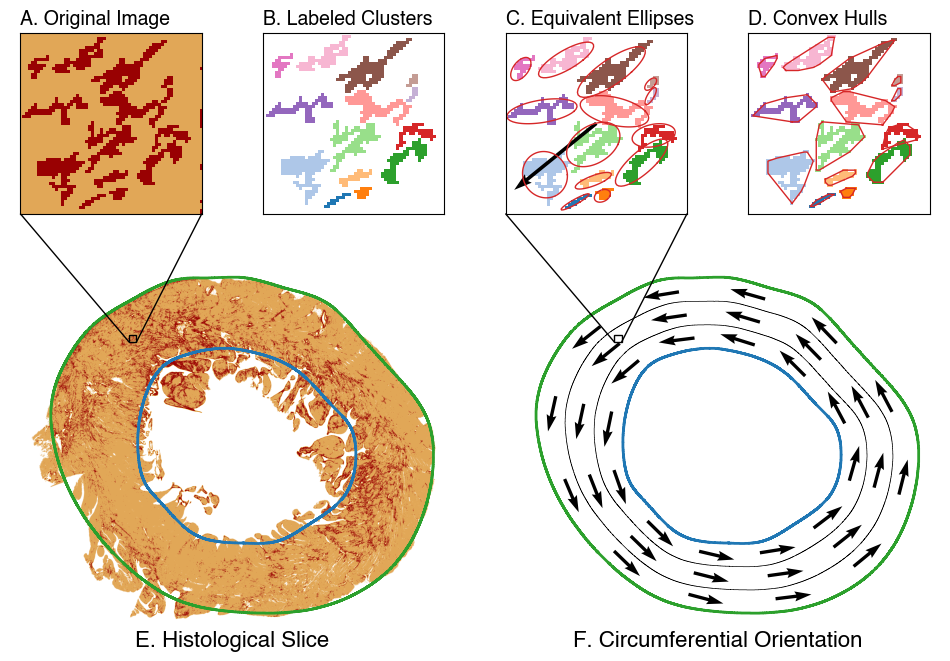

In [7]:
from fibrosisanalysis.analysis.objects_properties import ObjectsPropertiesBuilder
plt.rc('font', family='Helvetica')
# y0 = 2400
# dy0 = 100
# x0 = 970
# dx0 = 100

y0 = 2440
dy0 = 60
x0 = 990
dx0 = 60

edge_colors = ['#1f77b4', '#2ca02c']

fig = plt.figure(figsize=(12, 8))

axs = fig.subplot_mosaic([['clusters', 'labels', 'ellipse', 'convex'],
                          ['image', 'image', 'circ_orient', 'circ_orient'],
                          ['image', 'image', 'circ_orient', 'circ_orient'],])

axs['image'].sharex(axs['circ_orient'])
axs['image'].sharey(axs['circ_orient'])
# IMAGE
ax = axs['image']
ax.imshow(image_or, cmap=cmap, origin='lower', aspect='equal')
draw_edges(axs['image'], edges, edge_colors)
ax.set_title('E. Histological Slice', y=-0.05, fontweight=600,
                         fontsize=16)

draw_edges(axs['circ_orient'], edges, edge_colors)
draw_inner_edges(axs['circ_orient'], edges)
axs['circ_orient'].set_title('F. Circumferential Orientation', y=-0.05, fontweight=600,
                         fontsize=16)

# ORIENTATION
draw_orientation(axs['circ_orient'], centroids, edge_direction)

# ZOOM
draw_zoom(axs['clusters'], image_or, x0, y0, dx0, dy0)
axs['clusters'].set_title('A. Original Image', loc='left', fontweight=600,
                         fontsize=14)
ax.indicate_inset_zoom(axs['clusters'], edgecolor="black", lw=1, alpha=1)

# LABELS
x1, x2, y1, y2 = x0, x0 + dx0, y0, y0 + dy0
image_zoom = image_or[y1:y2, x1:x2]
labeled = label_clusters(image_zoom, 10)

draw_labels(axs['labels'], labeled)
axs["labels"].set_title('B. Labeled Clusters', loc='left', fontweight=600,
                         fontsize=14)

# ELLIPSES
labeled_shifted = np.zeros_like(image_or)
labeled_shifted[y1:y2, x1:x2] = labeled

objects_props_builder = ObjectsPropertiesBuilder()
objects_props = objects_props_builder.build_props(labeled_shifted > 0)
draw_labels(axs['ellipse'], labeled_shifted)
draw_ellipses(axs['ellipse'], objects_props)
axs['ellipse'].set_title('C. Equivalent Ellipses', loc='left', fontweight=600,
                         fontsize=14)
axs['ellipse'].set_xlim(x1, x2)
axs['ellipse'].set_ylim(y1, y2)
draw_orientation_point(axs['ellipse'], centroids, edge_direction,
                       x0 + 0.5 * dx0, y0 + 0.5 * dy0)

axs['circ_orient'].indicate_inset_zoom(axs['ellipse'],
                                       edgecolor="black",
                                       lw=1,
                                       alpha=1)

# CONVEX HULL
draw_labels(axs['convex'], labeled)
draw_convex_hull(axs['convex'], labeled)
axs['convex'].set_title('D. Convex Hulls', loc='left', fontweight=600,
                        fontsize=14)

plt.show()
# plt.tight_layout()

In [8]:
path_save = Path('/Users/arstanbek/Projects/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('histological_slice.png'),
            dpi=300, bbox_inches='tight')